# Search for Starlink traces in ZTF alerts with Fink

Satellites and asteroids are numerous each night to pass by the telescope during observations. While asteroids are of interest to study the solar system, satellites are typically masked. Satellites are very bright (Starlink satellite are around mag 5), and sometimes masking the main track is not enough. Reflections or other artifacts such as crosstalk can happen that lead to spurious alerts. The reader will find results of this analysis on these [slides](https://docs.google.com/presentation/d/1m7gV7zLYMbe2TrjDpIUVUpXYNFf1tGu1e4wuc--lXyo/edit?usp=sharing).

This notebook explores the possibility of contamination by Starlink satellites close to their main orbits. Of course, this can be extended to any satellites for which we have the orbital information.

<img src="img/Fink_PrimaryLogo_WEB.png" alt="drawing" width="500"/>

In [1]:
import sys
os.sys.path.insert(0, os.path.realpath('../../externals/'))

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from skyfield.api import Topos, load
from cmb_footprint import footprint

from astropy.coordinates import SkyCoord
import astropy.units as u

from fink_client.visualisation import show_stamps

## Loading Fink data with Apache Spark

In order to accommodate the paradigm change introduced by the multi-TB alert data set of LSST, Fink is designed to take advantage of new technological approaches based on big data tools. We primarily use [Apache Spark](https://spark.apache.org/) to efficiently manipulate the data. Let's load raw data from 4 August 2020 by Fink, stored on the VirtualData cloud:

In [2]:
df = spark.read.format('parquet').load('ztf_alerts/science_reprocessed/year=2020/month=08/day=04')

In [3]:
# Number of alerts that survived quality cuts
print('{} alerts pass the quality cuts'.format(df.count()))

82378 alerts pass the quality cuts


Let's compute the boundaries of the survey this night:

In [4]:
# RA/Dec for all alerts
radec = df.select('candidate.ra', 'candidate.dec').collect()
ra, dec = np.transpose(radec)

# Time boundaries of the survey
pdf_jd = df.select('candidate.jd').describe().toPandas()
jd_min = np.array(pdf_jd[pdf_jd['summary'] == 'min'][['jd']].values[0], dtype=float)[0]
jd_max = np.array(pdf_jd[pdf_jd['summary'] == 'max'][['jd']].values[0], dtype=float)[0]

and let's define some utilities for later

In [5]:
def dec2theta(dec: float) -> float:
    """ Convert Dec (deg) to theta (rad)
    """
    return np.pi / 2.0 - np.pi / 180.0 * dec

def ra2phi(ra: float) -> float:
    """ Convert RA (deg) to phi (rad)
    """
    return np.pi / 180.0 * ra

def thetaphi_starlink(positions: list, index: int):
    """ Return (theta, phi) in (deg, deg) for the Starlink number `index`
    """
    theta_starlink = dec2theta(positions[index][1]._degrees)
    phi_starlink = ra2phi(positions[index][0]._degrees)
    return theta_starlink, phi_starlink

## Computing Starlink satellite positions

Satellite data are given as two-line element (TLE) format. It is easy to reconstruct tracks from it, but it comes with some [limitations](https://rhodesmill.org/skyfield/earth-satellites.html#earth-satellites) though.

In [6]:
ts = load.timescale()

# Beware that this URL is only valid for a limited range of dates 
# (typically a few days).
stations_url = 'https://www.celestrak.com/NORAD/elements/supplemental/starlink.txt'
satellites = load.tle_file(stations_url)

# Observations are done from the Palomar observatory
palomar = Topos('33.3563 N', '116.8650 W')
difference = [sat - palomar for sat in satellites]

# Compute RA/Dec for satellites during the night
jds = np.linspace(jd_min, jd_max, 400)
positions = [sat.at(ts.tt_jd(jds)).radec()[0:2] for sat in difference]

Let's inspect the sky coverage this night:

/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


Showing 10 satellite(s)


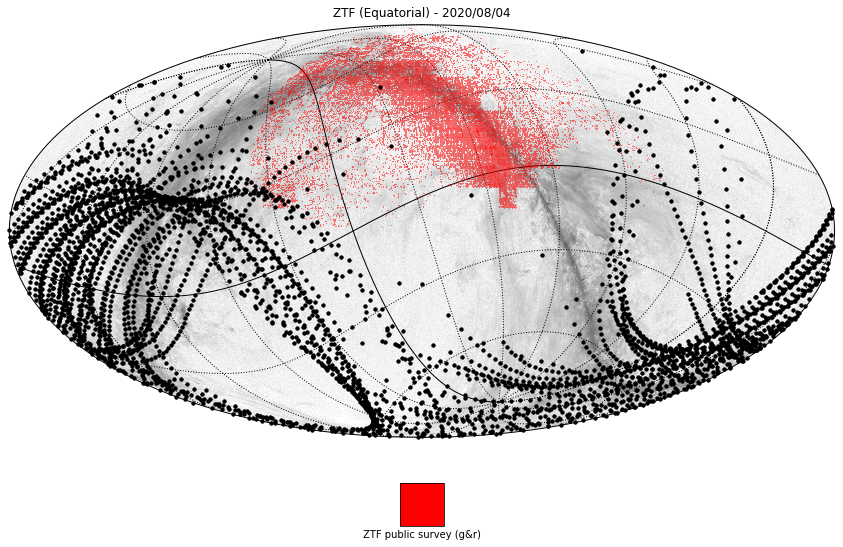

In [7]:
nside = 128
coord = 'E'
fig = plt.figure(figsize=(12, 12))
maxsatellite = 10

def gen_fast_map(ip_, nside):
    """ Quick and dirty projection on sky
    """
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_,minlength=npixel)
    return np.array(map_, dtype=float)

m = hp.ang2pix(nside, dec2theta(dec), ra2phi(ra), nest=False, lonlat=False)

## Plot the background
fp = footprint.SurveyStack(
    'PLANCK-DUSTPOL', fignum=1,
    title='ZTF (Equatorial) - 2020/08/04', 
    projection='mollweide', coord_plot=coord, rot=[-30, 0],
    config='/home/julien.peloton/externals/cmb_footprint/footprint.cfg'
)

fp.superimpose_hpxmap(
    gen_fast_map(m, nside), 
    label='ZTF public survey (g&r)', 
    coord_in=coord
)

# we print only 10 starlink satellite track
print('Showing {} satellite(s)'.format(maxsatellite))
for i in range(len(positions[0:maxsatellite])):
    hp.projscatter(
        thetaphi_starlink(positions, i), 
        lonlat=False, 
        color='black', 
        coord=coord, 
        marker='.'
    )

Red coverage represents all alerts emitted by ZTF on 2020/08/04 (public survey). Black dots are for 10 individual Starlink paths over the night (sampled). The satellites are most of the time outside the region of observation.

## Credible ZTF candidates to Starlink passages

Let's reduce the stream by selecting only potential satellite candidates. As we do not have a module to search for satellites, we will define our criteria by the negation. We want alerts that 

- Are not associated to a known objectId (1st time detection)
- Have no counterpart in the Simbad catalog (1’’)
- Have no counterpart in the Gaia or PanSTARRS catalogs (5’’)
- Are not a known asteroid

In addition, we add two quality cuts:

- the Fink quality cuts (already applied here)
- The Deep Learning Real-Bogus score `drb` > 0.5

In [8]:
df_candidate = df.filter(df['cdsxmatch'] == 'Unknown')\
    .filter(df['candidate.drb'] > 0.5)\
    .filter(df['candidate.ndethist'] == 1)\
    .filter((df['candidate.neargaia'] > 5) | (df['candidate.neargaia'] < 0))\
    .filter((df['candidate.distpsnr1'] > 5) | (df['candidate.distpsnr1'] < 0))\
    .filter(df['candidate.ssdistnr'] < 0)

df_candidate.count()

57

We have only 57 candidates that satisfy those cuts. Let's inspect visually the image data:

In [9]:
alerts = df_candidate.toPandas().to_dict(orient='records')

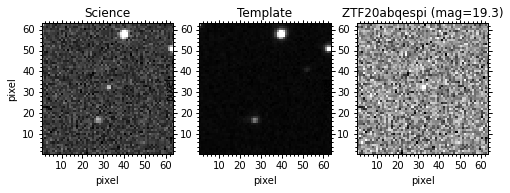

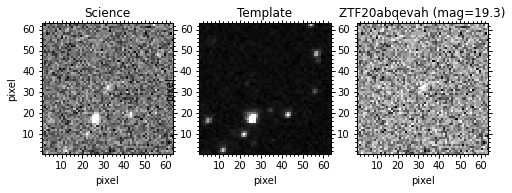

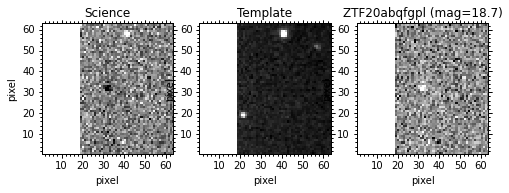

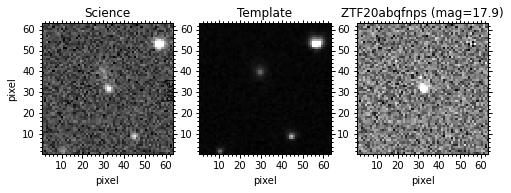

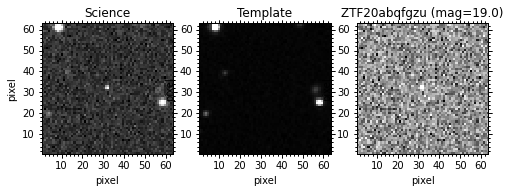

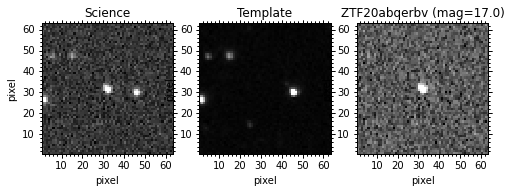

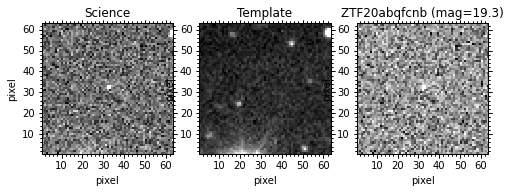

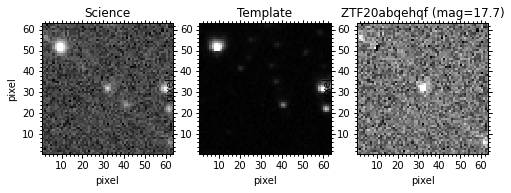

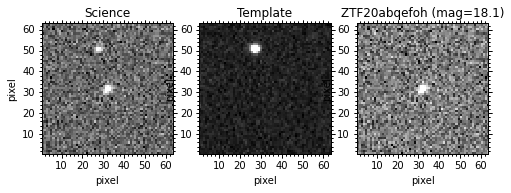

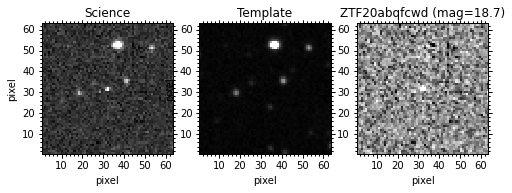

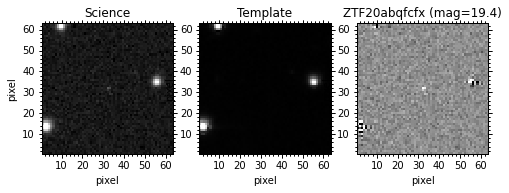

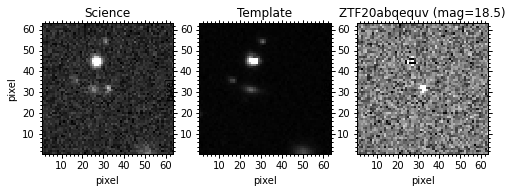

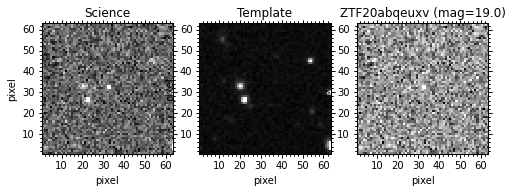

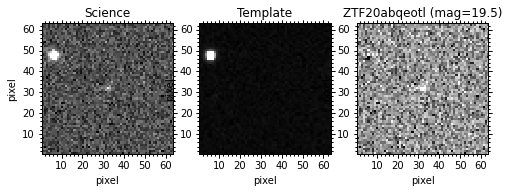

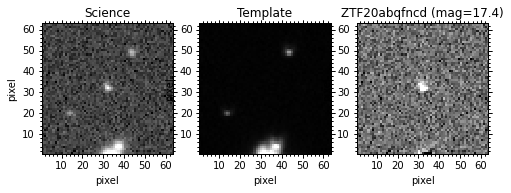

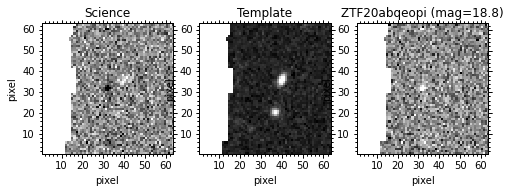

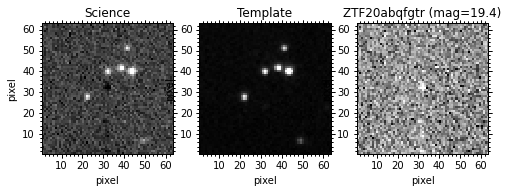

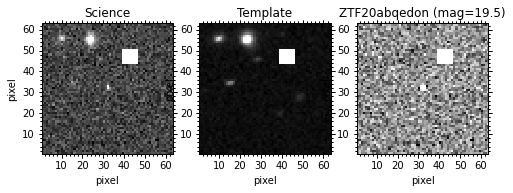

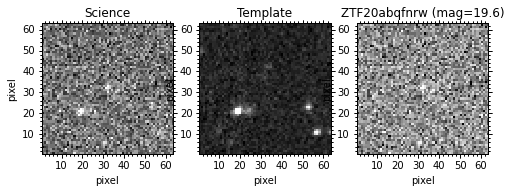

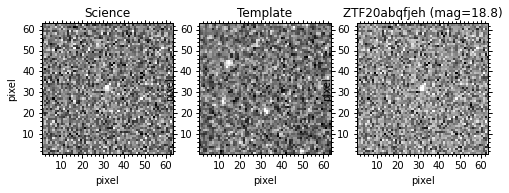

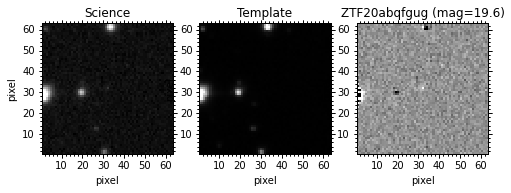

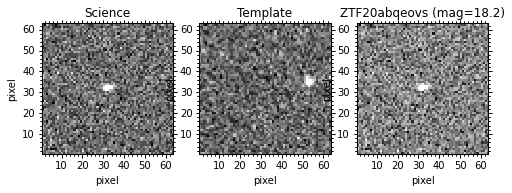

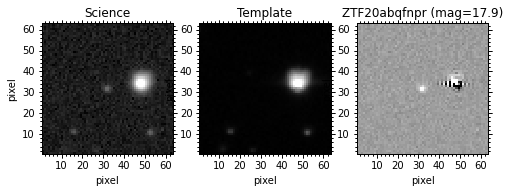

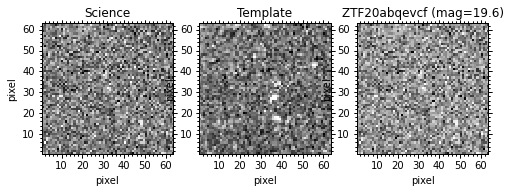

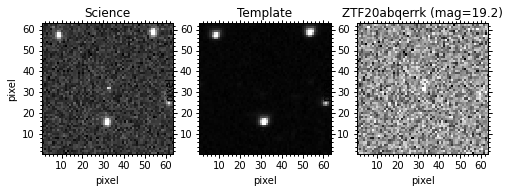

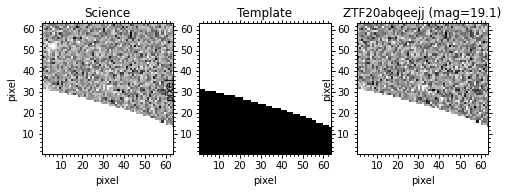

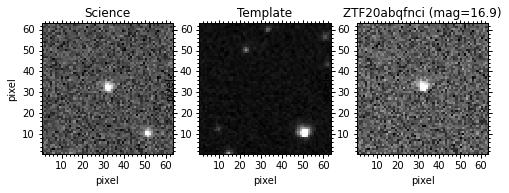

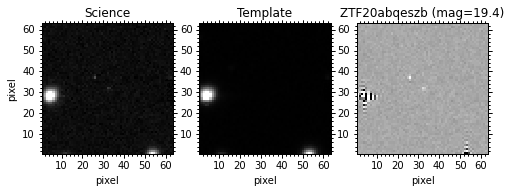

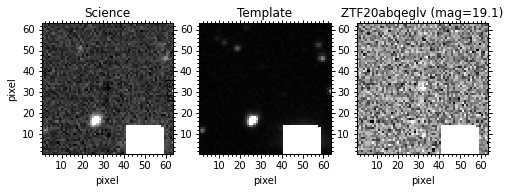

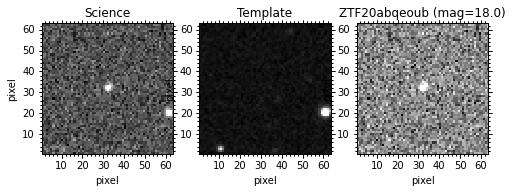

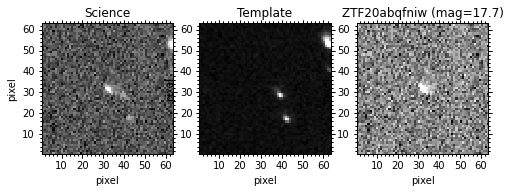

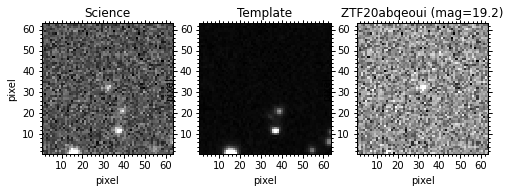

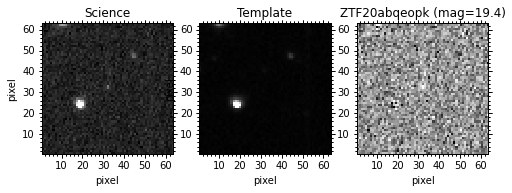

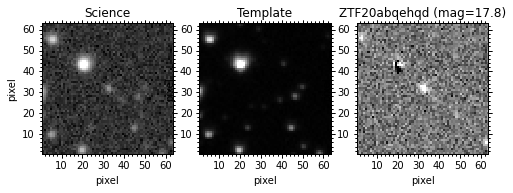

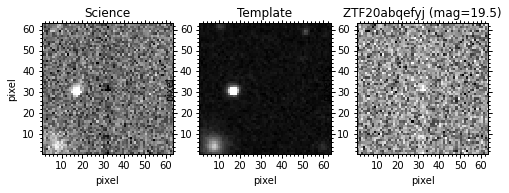

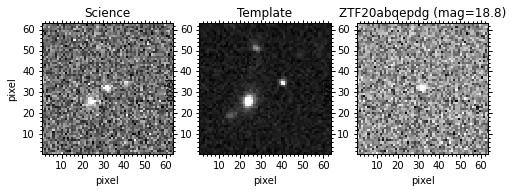

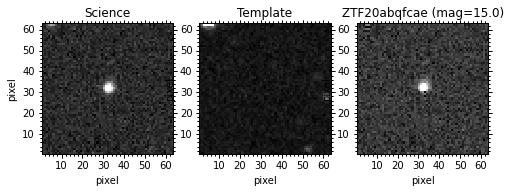

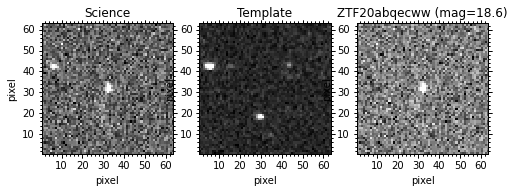

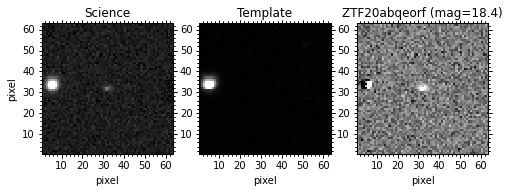

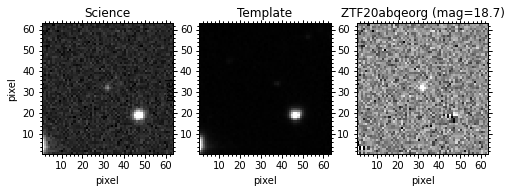

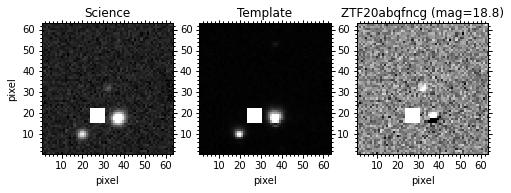

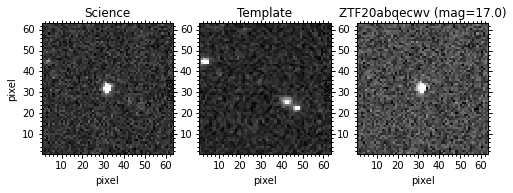

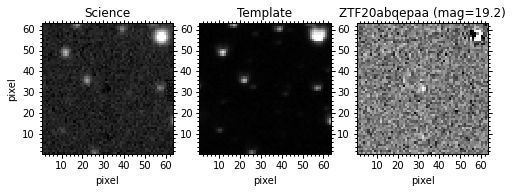

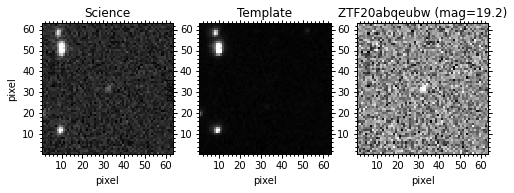

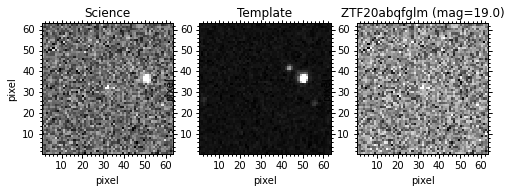

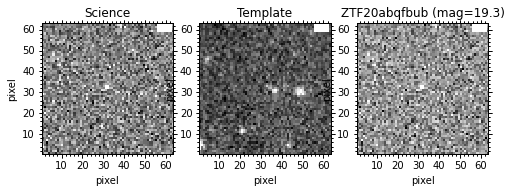

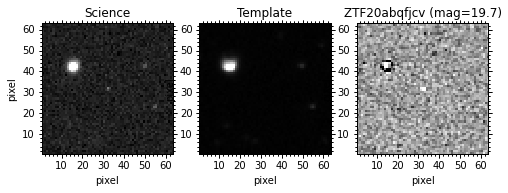

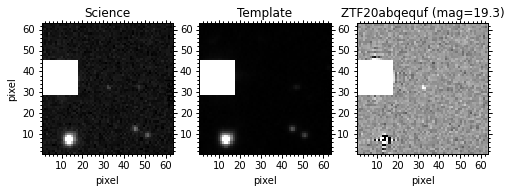

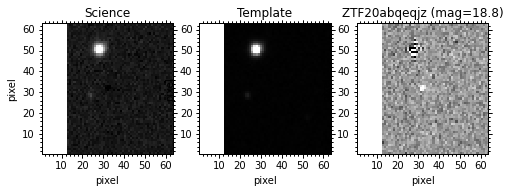

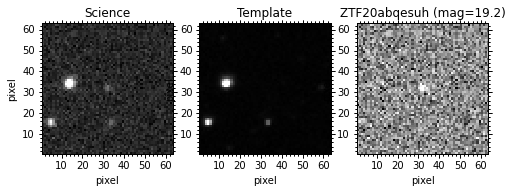

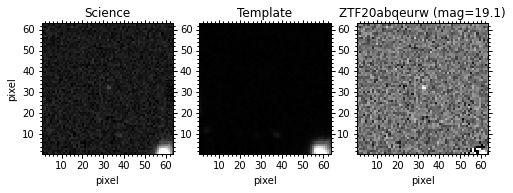

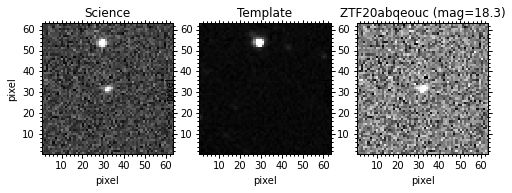

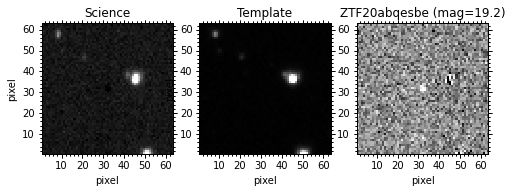

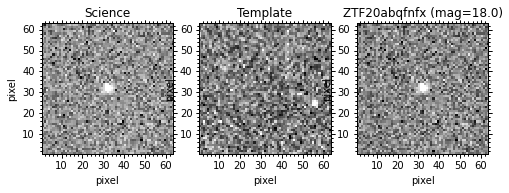

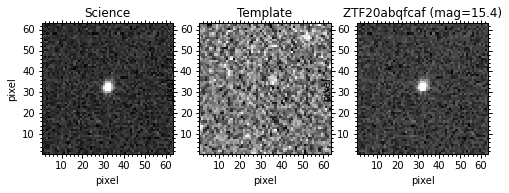

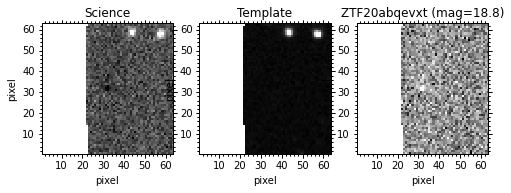

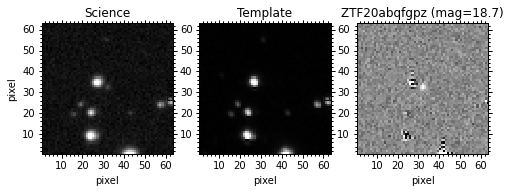

In [10]:
# to remove messages from aplpy
import logging, sys
logging.disable(sys.maxsize)

for alert in alerts:
    fig = plt.figure(figsize=(8, 4))
    show_stamps(alert, fig)
    plt.title('{} (mag={:.1f})'.format(alert['objectId'], alert['candidate']['magpsf']))
    plt.show()

Most of them are probably uncatalogued asteroids. Visually, only `ZTF20abqehqf` and `ZTF20abqehqd` have tracks that look like satellites. 

## Angular separation between ZTF alerts and Starlink satellites

Finally, let's compute the separation between the satellites and ZTF candidates. Satellite tracks are discrete, and given the velocity (a few degree per observation) it is easy to miss a match if the sampling is too wide:

/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):



    Alert ZTF20abqehqf
    Angular separation (arcmin): 7.050077442159145
    Corresponding satellite: STARLINK-1366
    

    Alert ZTF20abqehqd
    Angular separation (arcmin): 11.521363104403173
    Corresponding satellite: STARLINK-1366
    


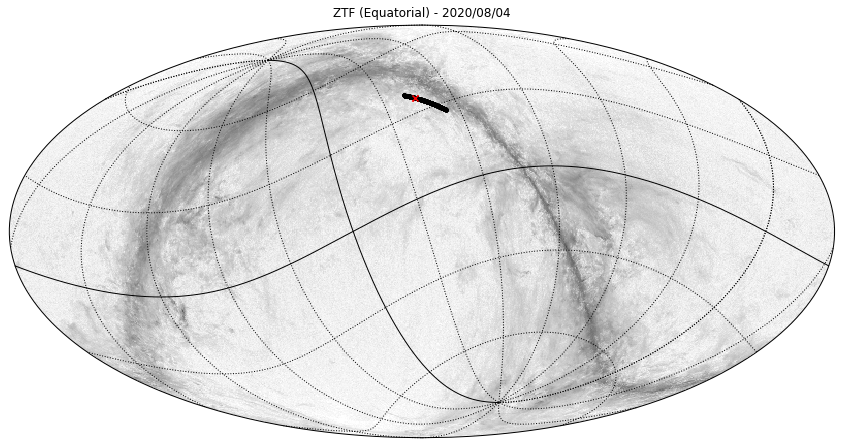

In [11]:
nside = 128
coord = 'E'
fig = plt.figure(figsize=(12, 12))
    
## Plot the background
fp = footprint.SurveyStack(
    'PLANCK-DUSTPOL', fignum=1,
    title='ZTF (Equatorial) - 2020/08/04', 
    projection='mollweide', coord_plot=coord, rot=[-30, 0],
    config='/home/julien.peloton/externals/cmb_footprint/footprint.cfg'
)

for alert in alerts:
    if alert['objectId'] not in ['ZTF20abqehqf', 'ZTF20abqehqd']:
        continue
    
    # Compute vectors of jds and satellite positions
    # We center on jd0, the alert emission date, and
    # compute 300 points between jd0 - 15second, jd0 + 15second
    jd0 = alert['candidate']['jd']
    shift = 0.25 / (24. * 60.)
    jds = np.linspace(jd0 - shift, jd0 + shift, 300)
    positions = [sat.at(ts.tt_jd(jds)).radec()[0:2] for sat in difference]
    
    # Alert information
    ra0 = alert['candidate']['ra']
    dec0 = alert['candidate']['dec']
    c_ztf = SkyCoord(ra=ra0, dec=dec0, unit=(u.deg, u.deg))

    # Compute angular separation
    c_starlinks = [
        SkyCoord(
            ra=pos[0]._degrees, 
            dec=pos[1]._degrees, 
            unit=(u.deg, u.deg)
        ) for pos in positions
    ]
    separations = [c_ztf.separation(c_starlink).deg for c_starlink in c_starlinks]
    
    minsep = np.min(separations)
    satellite_index = np.where(separations == minsep)[0][0]
    
    msg = """
    Alert {}
    Angular separation (arcmin): {}
    Corresponding satellite: {}
    """.format(alert['objectId'], minsep * 60., satellites[satellite_index].name)
    
    print(msg)

    # Project statellite track
    hp.projscatter(
        thetaphi_starlink(
            positions, 
            satellite_index
        ), lonlat=False, 
        color='black', 
        coord=coord, 
        marker='.'
    )
    
    # Project alert position
    hp.projscatter(
        dec2theta(dec0), 
        ra2phi(ra0), 
        lonlat=False, 
        color='red', 
        coord=coord, 
        marker='x'
    )    

Bingo! Those two alerts were emitted close to starlink-1366 around 6 UTC. We can confirm this by seeing the satellite passing over the USA at this date:

<img src="img/starlink-1366.png" alt="drawing" width="1000"/>

So, are we really seeing a Starlink in ZTF data? 

Probably not. At least, _not directly_.

First the separation, even though it is small, remains quite large to be a strong one (several arcminutes). Second, the magnitudes of the alerts are faint for being a satellite (around 17.7). And yet, the association seems there: right position on the sky, right time. Just a bit far, and too faint... It could be the sign of reflections or crosstalk. _Affaire à suivre!_